# Which One Doesn't Belong (WODB)

### Setup

#### Importing PWE (Possible Worlds Explorer = ASP + Python)

In [1]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.run_clingo import run_clingo
from PW_explorer.helper import pw_slicer, rel_slicer
from PW_explorer.query import PWEQuery
from PW_explorer.dist_calc import PWEDistanceCalculation
from PW_explorer.visualize import PWEVisualization

In [2]:
%load_ext PWE_NB_Extension

Importing some other common python libraries

In [3]:
import numpy as np
import pandas as pd

#### Importing Visualization Functions
Here we import some visualization functions and tools to aid us in our analysis.

In [4]:
# Custom code
from wodb_viz_lib import WODBVizLib

In [5]:
# Standard Python Graphviz Library
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

### A Simple Example

<img src="wodb-simple-1.png" alt="WODB" style="width: 200px;"/>
Which one of the above stands out?

To us pretty clearly the one with the smallest size stands out.

In general, the answer depends on what we can observe and more importantly what we care about.

### Property Facts Database

One way to formalize our thinking of the objects we want to analyze is to represent their properties in a DB.

In [6]:
%%clingo --donot-run -lci db1 --donot-display_input

% schema propDB(figure_ID, property_name, property_value)
% schema prop(property_name)
prop(X) :- propDB(_,X,_).

% Figure 1
propDB(f1,style,bold).
propDB(f1,color,white).
propDB(f1,size,large).
propDB(f1,shape,square).

% Figure 2
propDB(f2,style,bold).
propDB(f2,color,white).
propDB(f2,size,large).
propDB(f2,shape,square).

% Figure 3
propDB(f3,style,bold).
propDB(f3,color,white).
propDB(f3,size,large).
propDB(f3,shape,square).

% Figure 4
propDB(f4,style,bold).
propDB(f4,color,white).
propDB(f4,size,small).
propDB(f4,shape,square).

We can easily visualize the DB and its instances using the simple custom visualization library we imported earlier:

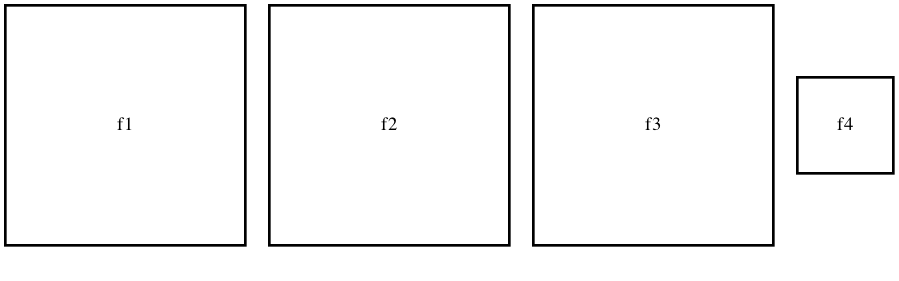

In [7]:
display(draw(WODBVizLib.visualize_figure_from_asp_rules(db1)))

### Defining Queries to choose TODB (The One that Doesn't Belong)

One formal way to analyze and look for WODB is to use queries, more specifically Datalog/ASP queries.

##### Query: Only one to have a specific value V for property P

One natural query is to check if any of the figures have a unique value for any property.

We can encode this as follows:

In [8]:
%%clingo -lci unique_property_value_query --donot-display_input --donot-run

% figure F and figure F1 both have the same value for their property P
shared_prop(F,F1,P,V) :- propDB(F,P,V), propDB(F1,P,V), F != F1.

% choose exactly 1 property to focus on
1 {unique_prop(P) : prop(P)} 1.

% figure F is unique with respect to property P 
% i.e. no other figure has value V for property P
soln(F,P) :- unique_prop(P), propDB(F,P,_), not shared_prop(F,_,P,_).

% figure F is special wrt some property-value pair
soln(F) :- soln(F,_).

soln_count(N) :-  #count {F: soln(F)} = N.
:- soln_count(N), N <= 0.

We can now run this query on our database instance as follows:

In [9]:
%%clingo -l unique_property_value_query db1 --donot-display_input

#show soln/2.
#show soln/1.
#show unique_prop/1.
#show soln_count/1.

Output:


'Answer: 1\nsoln(f4,size) soln(f4) soln_count(1) unique_prop(size)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

As we can observe above from the DB and the figures themselves, the only distinguising property is their size.

In [10]:
%clingo -l unique_property_value_query db1 --donot-display_input --donot-display_output -exp unique_prop_val_exp

In [11]:
unique_prop_val_exp.keys()

dict_keys(['asp_rules', 'asp_soln', 'meta_data'])

In [12]:
unique_prop_val_exp['pws_rels_dfs'], unique_prop_val_exp['rel_schemas'], unique_prop_val_exp['pw_objects'] \
= load_worlds(unique_prop_val_exp['asp_soln'], meta_data=unique_prop_val_exp['meta_data'])

Number of Models: 1


In [13]:
unique_prop_val_exp['pws_rels_dfs'].keys()

dict_keys(['propDB_3', 'shared_prop_4', 'prop_1', 'soln_2', 'soln_1', 'soln_count_1', 'unique_prop_1'])

In [14]:
unique_prop_val_exp['pws_rels_dfs']['soln_2']

,pw,x1,x2
0,1,f4,size


We can get a visual representation of the solutions (PWs) as below along with the reasoning behind the solution.

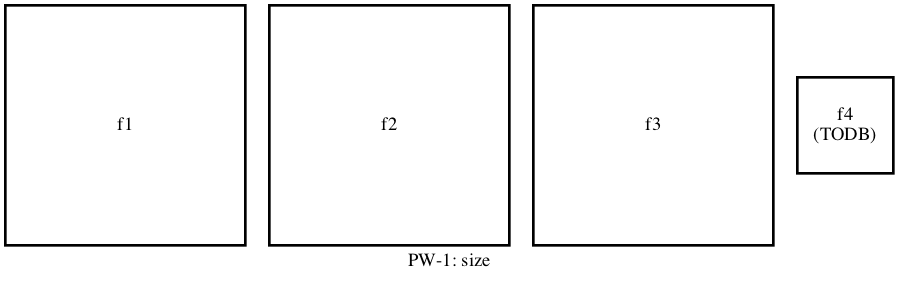

In [15]:
for i in range(1, len(unique_prop_val_exp['pw_objects'])+1):
    pw_i_rels_dfs, _ = pw_slicer(unique_prop_val_exp['pws_rels_dfs'], None, [i])
    reason_df = pw_i_rels_dfs['soln_2']
    todb_reason = reason_df.iloc[0]['x2']
    g = WODBVizLib.visualize_wodb_query_instance(pw_i_rels_dfs['propDB_3'], 
                                      pw_i_rels_dfs['soln_1'], 
                                      graph_label='PW-{}: {}'.format(str(i), todb_reason))
    display(draw(g))

We can now explore how to do something similar in Python instead of ASP.

In [16]:
%%clingo -lci pick_one_fig_query --donot-display_input --donot-run

% choosing criteria could be as simple as choosing exactly one figure
1 {soln(F) : propDB(F,_,_)} 1.

% schema soln_propDB(property_name, property_value)
soln_propDB(P,V) :- soln(F), propDB(F,P,V).

In [17]:
%clingo -l pick_one_fig_query db1 --donot-display_input --donot-display_output -exp pick_one_exp

In [18]:
pick_one_exp['pws_rels_dfs'], pick_one_exp['rel_schemas'], pick_one_exp['pw_objects'] \
= load_worlds(pick_one_exp['asp_soln'], meta_data=pick_one_exp['meta_data'])

Number of Models: 4


We encode the problem such that each figure is its own PW, allowing us to use PWE to analyze them, compare them, etc.

### Finding WODB in Python using PWE

We can also analysis similar to the one above using pure Python and some querying, numerical and visualization tools.

Let's consider each figure to be a PW (Possible World).

##### DB Query Based Analysis (similar to the unique_property_value_query)

In [19]:
_ = PWEQuery.unique_tuples(expected_pws=len(pick_one_exp['pw_objects']), 
                           dfs=pick_one_exp['pws_rels_dfs'], 
                           rl_name='soln_propDB_2')

The unique tuple  ('size', 'small') occurs only in PW 1


The above query finds tuples that exists in exactly one PW.

As we can see here, PW-2,3,4 (fig1,2,3) don't have any unique tuples. PW-1 (fig4) is the only one to have a unique tuple.

##### Distance Metric Based Analysis

Distance Metrics can be used to quantify how similar or different two PWs (figures in our case) are. These can be helpful to analyze the solution space and discover existing properties of the same.

In our case we use a distance metric based on the size of the symmetric-difference of two PWs.

In [20]:
PWEDistanceCalculation.sym_diff_dist(pw_id_1=1, pw_id_2=2, 
                                     relations=pick_one_exp['rel_schemas'], 
                                     dfs=pick_one_exp['pws_rels_dfs'], 
                                     pws=pick_one_exp['pw_objects'], 
                                     rls_to_use=['soln_propDB_2'])

2

Based on this metric, we can form a distance metric for our set of PWs.

In [21]:
num_pws = len(pick_one_exp['pw_objects'])
dist_matrix = np.zeros((num_pws, num_pws))
for i in range(num_pws):
    for j in range(i+1, num_pws):
        dist_matrix[i][j] = \
            dist_matrix[j][i] = \
                PWEDistanceCalculation.sym_diff_dist(pw_id_1=i+1, pw_id_2=j+1, 
                                                     relations=pick_one_exp['rel_schemas'],
                                                     dfs=pick_one_exp['pws_rels_dfs'],
                                                     pws=pick_one_exp['pw_objects'],
                                                     rls_to_use=['soln_propDB_2'])
        
pd.DataFrame(dist_matrix, index=range(1,len(dist_matrix)+1), columns=range(1, len(dist_matrix)+1))

,1,2,3,4
1,0.0,2.0,2.0,2.0
2,2.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0


We can already see here that while PWs-2,3,4 are all at a distance of 0 from each other (they are all the same), PW-1 is at a distance of 2 from the rest of the PWs.

We can visualize these PWs based on the distance matrix above to get a better visual sense of this.

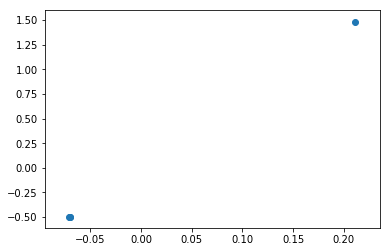

In [22]:
_ = PWEVisualization.mds_sklearn(dist_matrix)

We can clearly see the two clusters as expected.

We can also visualize the distance matrix in more informative and visually appealing ways such as a cluster-map as shown below:

/anaconda3/envs/LeanEuler-prod-env/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


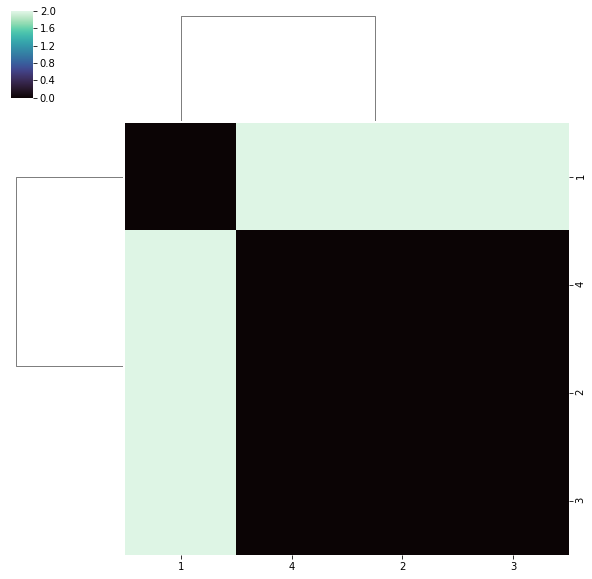

In [23]:
_ = PWEVisualization.cluster_map_viz(dist_matrix)

###### As we can observe, in all of these analyses, PW-1 (fig4) stands out and the rest are indistinguishable from each other.

#### So that was a very simple example to acclimate you to ASP and PWE and how we are going to leverage them here. Now we move onto more interesting examples.

### A slightly more interesting example

<img src="wodb-simple-4.png" alt="WODB" style="width: 200px;"/>

Just like our simple example, we can represent this as a simple Database instance as follows:

In [24]:
%%clingo --donot-run -lci db2 --donot-display_input

% schema propDB(figure_ID, property_name, property_value)
% schema prop(property_name)
prop(X) :- propDB(_,X,_).

% Figure 1
propDB(f1,style,thin).
propDB(f1,color,limegreen).
propDB(f1,size,large).
propDB(f1,shape,circle).

% Figure 2
propDB(f2,style,thin).
propDB(f2,color,chocolate).
propDB(f2,size,large).
propDB(f2,shape,circle).

% Figure 3
propDB(f3,style,thin).
propDB(f3,color,limegreen).
propDB(f3,size,large).
propDB(f3,shape,square).

% Figure 4
propDB(f4,style,thin).
propDB(f4,color,limegreen).
propDB(f4,size,large).
propDB(f4,shape,circle).

We visualize our DB just as before.

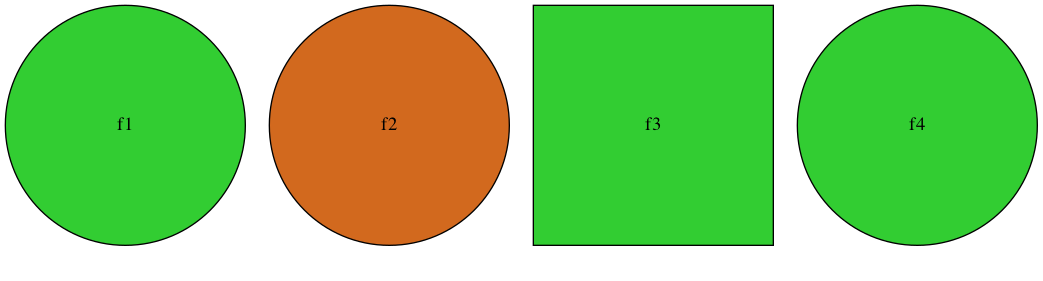

In [25]:
display(draw(WODBVizLib.visualize_figure_from_asp_rules(db2)))

##### But wait a second. What if the observer is color-blind?

<img src="wodb-simple-5.png" alt="WODB" style="width: 600px;"/>

A color-blind observer would not be able to reliably provide the color property. So, we must get rid of this property (or set it to the same generic value for all figures).

We do it as follows:

In [26]:
%%clingo --donot-run -lci db3 --donot-display_input

% schema propDB(figure_ID, property_name, property_value)
% schema prop(property_name)
prop(X) :- propDB(_,X,_).

% Figure 1
propDB(f1,style,thin).
propDB(f1,color,gray).   %%%% <--DIFFERENT %%%%
propDB(f1,size,large).
propDB(f1,shape,circle).

% Figure 2
propDB(f2,style,thin).
propDB(f2,color,gray).   %%%% <--DIFFERENT %%%%
propDB(f2,size,large).
propDB(f2,shape,circle).

% Figure 3
propDB(f3,style,thin).
propDB(f3,color,gray).   %%%% <--DIFFERENT %%%%
propDB(f3,size,large).
propDB(f3,shape,square).

% Figure 4
propDB(f4,style,thin).
propDB(f4,color,gray).   %%%% <--DIFFERENT %%%%
propDB(f4,size,large).
propDB(f4,shape,circle).

So this is what this DB looks like:

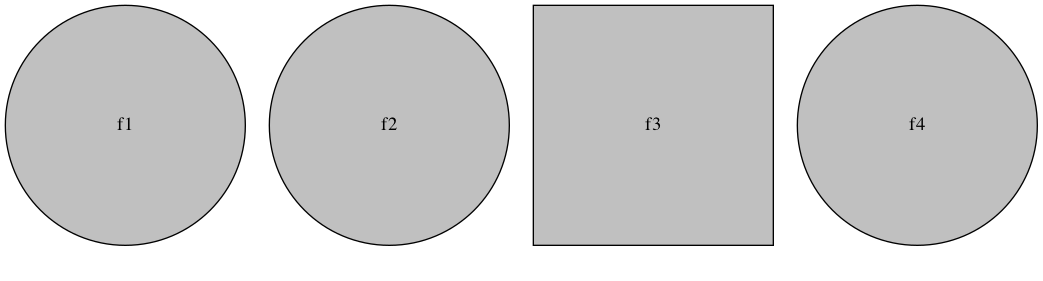

In [27]:
display(draw(WODBVizLib.visualize_figure_from_asp_rules(db3)))

##### Now we explore the what changing the "same" WODB instance affects the results of our query from earlier and our PWE-based analysis

Unique Property Value Query on DB2 (normal version)

In [28]:
%%clingo -l unique_property_value_query db2 --donot-display_input

#show soln/2.
#show soln/1.
#show unique_prop/1.
#show soln_count/1.

Output:


'Answer: 1\nsoln(f3,shape) unique_prop(shape) soln(f3) soln_count(1)\nAnswer: 2\nsoln(f2,color) unique_prop(color) soln(f2) soln_count(1)\nSATISFIABLE\n\nModels       : 2\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

As we can observe above from the DB and the figures themselves, the distinguising property can be their color or the shape of the figure.

Same query on DB3 (color-agnostic version)

In [29]:
%%clingo -l unique_property_value_query db3 --donot-display_input

#show soln/2.
#show soln/1.
#show unique_prop/1.
#show soln_count/1.

Output:


'Answer: 1\nsoln(f3,shape) soln(f3) soln_count(1) unique_prop(shape)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

As we can observe above from the DB and the figures themselves, the only distinguising property can be their shape.

In [30]:
%clingo -l unique_property_value_query db2 --donot-display_input --donot-display_output -exp unique_prop_val_exp

In [31]:
unique_prop_val_exp['pws_rels_dfs'], unique_prop_val_exp['rel_schemas'], unique_prop_val_exp['pw_objects'] \
= load_worlds(unique_prop_val_exp['asp_soln'], meta_data=unique_prop_val_exp['meta_data'])

Number of Models: 2


We can get a visual representation of the solutions (PWs) as below along with the reasoning behind the solution.

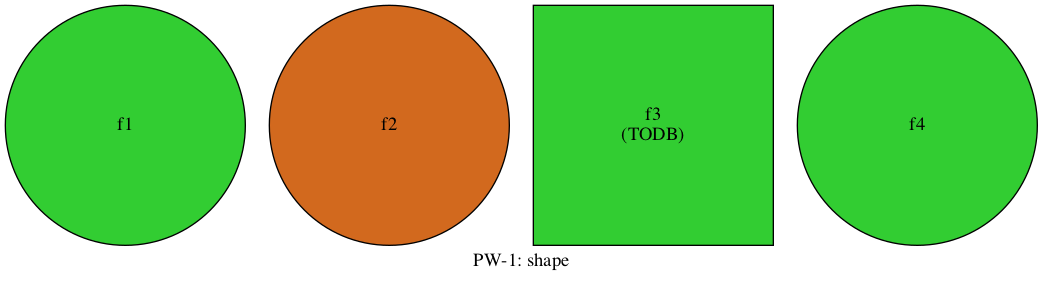

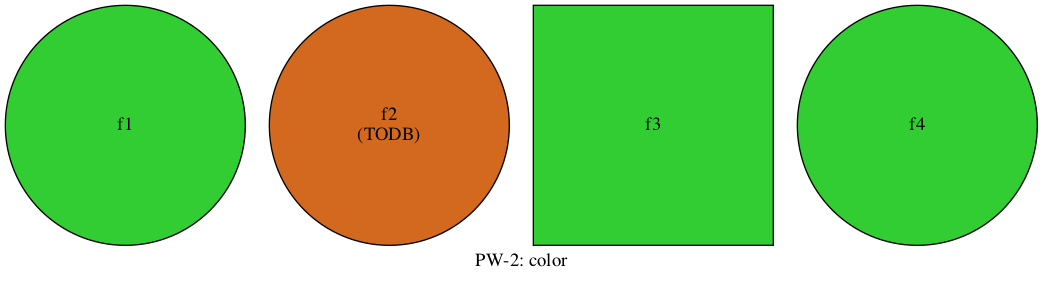

In [32]:
for i in range(1, len(unique_prop_val_exp['pw_objects'])+1):
    pw_i_rels_dfs, _ = pw_slicer(unique_prop_val_exp['pws_rels_dfs'], None, [i])
    reason_df = pw_i_rels_dfs['soln_2']
    todb_reason = reason_df.iloc[0]['x2']
    g = WODBVizLib.visualize_wodb_query_instance(pw_i_rels_dfs['propDB_3'], 
                                      pw_i_rels_dfs['soln_1'], 
                                      graph_label='PW-{}: {}'.format(str(i), todb_reason))
    display(draw(g))

In [33]:
%clingo -l unique_property_value_query db3 --donot-display_input --donot-display_output -exp unique_prop_val_exp

In [34]:
unique_prop_val_exp['pws_rels_dfs'], unique_prop_val_exp['rel_schemas'], unique_prop_val_exp['pw_objects'] \
= load_worlds(unique_prop_val_exp['asp_soln'], meta_data=unique_prop_val_exp['meta_data'])

Number of Models: 1


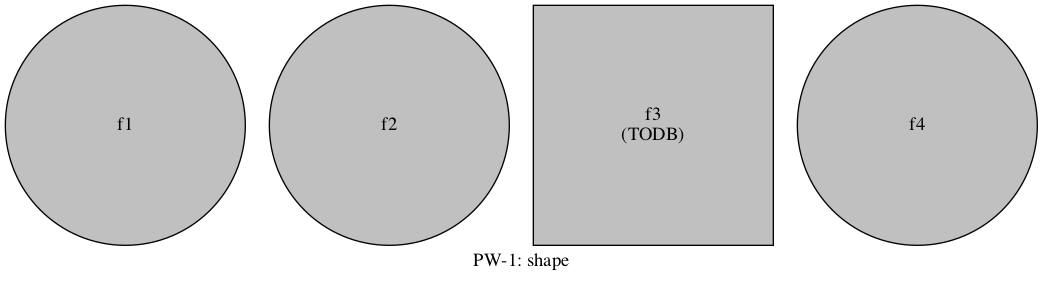

In [35]:
for i in range(1, len(unique_prop_val_exp['pw_objects'])+1):
    pw_i_rels_dfs, _ = pw_slicer(unique_prop_val_exp['pws_rels_dfs'], None, [i])
    reason_df = pw_i_rels_dfs['soln_2']
    todb_reason = reason_df.iloc[0]['x2']
    g = WODBVizLib.visualize_wodb_query_instance(pw_i_rels_dfs['propDB_3'], 
                                      pw_i_rels_dfs['soln_1'], 
                                      graph_label='PW-{}: {}'.format(str(i), todb_reason))
    display(draw(g))

As we can see, in case of DB2 we get 2 PWs as expected, but only 1 PW for the modified color-agnostic version.

Now we see how the DBs compare in the PWE-based analysis.

In [36]:
%clingo -l pick_one_fig_query db2 --donot-display_input --donot-display_output -exp pick_one_exp_db2

In [37]:
pick_one_exp_db2['pws_rels_dfs'], pick_one_exp_db2['rel_schemas'], pick_one_exp_db2['pw_objects'] \
= load_worlds(pick_one_exp_db2['asp_soln'], meta_data=pick_one_exp_db2['meta_data'], silent=True)

In [38]:
%clingo -l pick_one_fig_query db3 --donot-display_input --donot-display_output -exp pick_one_exp_db3

In [39]:
pick_one_exp_db3['pws_rels_dfs'], pick_one_exp_db3['rel_schemas'], pick_one_exp_db3['pw_objects'] \
= load_worlds(pick_one_exp_db3['asp_soln'], meta_data=pick_one_exp_db3['meta_data'], silent=True)

Again, each figure is a PW of its own.

##### DB Query Based Analysis (similar to the unique_property_value_query)

On DB2:

In [40]:
_ = PWEQuery.unique_tuples(expected_pws=len(pick_one_exp_db2['pw_objects']), 
                           dfs=pick_one_exp_db2['pws_rels_dfs'], 
                           rl_name='soln_propDB_2')

The unique tuple  ('shape', 'square') occurs only in PW 1
The unique tuple  ('color', 'chocolate') occurs only in PW 2


On DB3:

In [41]:
_ = PWEQuery.unique_tuples(expected_pws=len(pick_one_exp_db3['pw_objects']), 
                           dfs=pick_one_exp_db3['pws_rels_dfs'], 
                           rl_name='soln_propDB_2')

The unique tuple  ('shape', 'square') occurs only in PW 1


As we predicted, the solutions are different.

##### Distance Metric Based Analysis

On DB2:

In [42]:
num_pws = len(pick_one_exp_db2['pw_objects'])
dist_matrix_db2 = np.zeros((num_pws, num_pws))
for i in range(num_pws):
    for j in range(i+1, num_pws):
        dist_matrix_db2[i][j] = \
            dist_matrix_db2[j][i] = \
                PWEDistanceCalculation.sym_diff_dist(pw_id_1=i+1, pw_id_2=j+1, 
                                                     relations=pick_one_exp_db2['rel_schemas'],
                                                     dfs=pick_one_exp_db2['pws_rels_dfs'],
                                                     pws=pick_one_exp_db2['pw_objects'],
                                                     rls_to_use=['soln_propDB_2'])
        
pd.DataFrame(dist_matrix_db2, index=range(1,len(dist_matrix_db2)+1), columns=range(1, len(dist_matrix_db2)+1))

,1,2,3,4
1,0.0,4.0,2.0,2.0
2,4.0,0.0,2.0,2.0
3,2.0,2.0,0.0,0.0
4,2.0,2.0,0.0,0.0


On DB3:

In [43]:
num_pws = len(pick_one_exp_db3['pw_objects'])
dist_matrix_db3 = np.zeros((num_pws, num_pws))
for i in range(num_pws):
    for j in range(i+1, num_pws):
        dist_matrix_db3[i][j] = \
            dist_matrix_db3[j][i] = \
                PWEDistanceCalculation.sym_diff_dist(pw_id_1=i+1, pw_id_2=j+1, 
                                                     relations=pick_one_exp_db3['rel_schemas'],
                                                     dfs=pick_one_exp_db3['pws_rels_dfs'],
                                                     pws=pick_one_exp_db3['pw_objects'],
                                                     rls_to_use=['soln_propDB_2'])
        
pd.DataFrame(dist_matrix_db3, index=range(1,len(dist_matrix_db3)+1), columns=range(1, len(dist_matrix_db3)+1))

,1,2,3,4
1,0.0,2.0,2.0,2.0
2,2.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0


Now let's visualize these and see how the solution changes when we tweak the DBs.

DB2 Clusters:

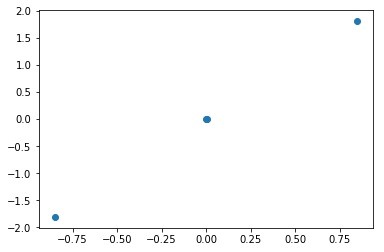

In [44]:
_ = PWEVisualization.mds_sklearn(dist_matrix_db2)

vs DB3 Clusters:

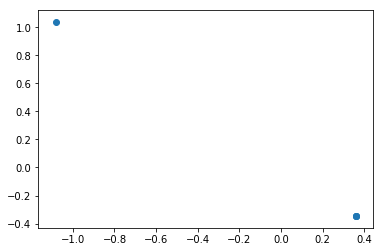

In [45]:
_ = PWEVisualization.mds_sklearn(dist_matrix_db3)

As we can clearly see, DB2 has 3 clusters, while DB2 only has 2.

We can see this more clearly in the cluster map visualization below:

DB2:

/anaconda3/envs/LeanEuler-prod-env/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


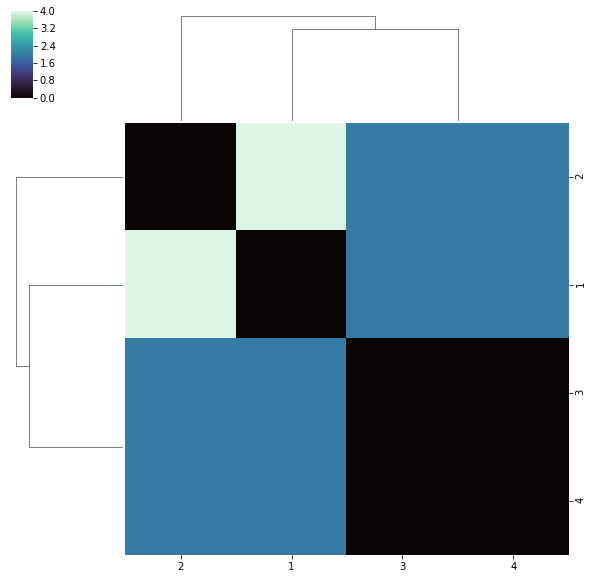

In [46]:
_ = PWEVisualization.cluster_map_viz(dist_matrix_db2)

DB3:

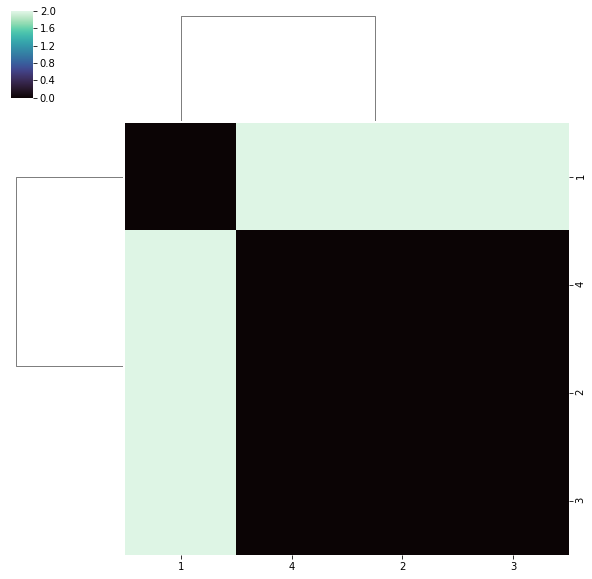

In [47]:
_ = PWEVisualization.cluster_map_viz(dist_matrix_db3)

#### As we have just demonstrated, chaning the DB even slightly, to account for observability, etc. can change the results substantially even on the same queries. Hence, before any such analysis, it is vital to agree upon a DB Schema and the properties we want to and can put in the database.

### The really interesting mind-bending example

![WODB](which-does-not-belong.jpg)
Which one of the above stands out?
The GREEN one? The CIRCLE? The SMALL one? The one without the BORDER? Or is it the one that doesn't stand out for any reason at all?

The answer depends on what we can observe and more importantly what we care about.

As before, we model the figures as below:

In [48]:
%%clingo --donot-run -lci db4 --donot-display_input

% schema propDB(figure_ID, property_name, property_value)
% schema prop(property_name)
prop(X) :- propDB(_,X,_).

% Figure 1
propDB(f1,style,bold).
propDB(f1,size,large).
propDB(f1,color,red).
propDB(f1,shape,circle).

% Figure 2
propDB(f2,style,bold).
propDB(f2,size,large).
propDB(f2,color,green).
propDB(f2,shape,square).

% Figure 3
propDB(f3,style,bold).
propDB(f3,size,large).
propDB(f3,color,red).
propDB(f3,shape,square).

% Figure 4
propDB(f4,style,thin).
propDB(f4,size,large).
propDB(f4,color,red).
propDB(f4,shape,square).

% Figure 5
propDB(f5,style,bold).
propDB(f5,size,small).
propDB(f5,color,red).
propDB(f5,shape,square).

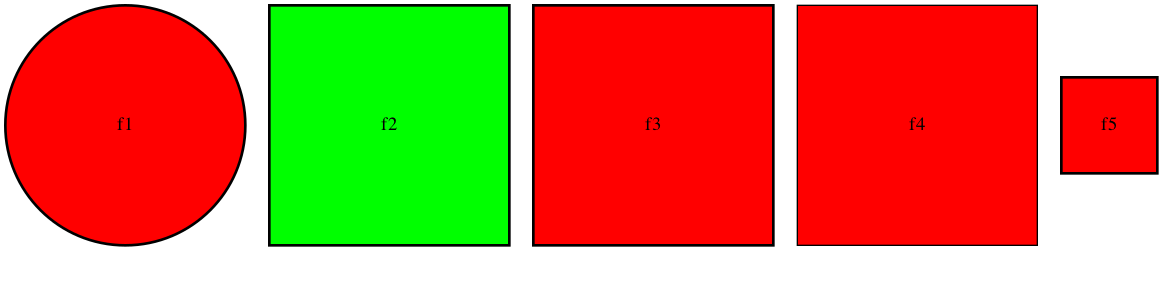

In [49]:
display(draw(WODBVizLib.visualize_figure_from_asp_rules(db4)))

#### Now let's run our unique property value query on this DB:

In [50]:
%%clingo -l unique_property_value_query db4 --donot-display_input

#show soln/2.
#show soln/1.
#show soln_count/1.
#show unique_prop/1.

Output:


'Answer: 1\nsoln(f4,style) unique_prop(style) soln(f4) soln_count(1)\nAnswer: 2\nsoln(f5,size) unique_prop(size) soln(f5) soln_count(1)\nAnswer: 3\nsoln(f2,color) unique_prop(color) soln(f2) soln_count(1)\nAnswer: 4\nsoln(f1,shape) unique_prop(shape) soln(f1) soln_count(1)\nSATISFIABLE\n\nModels       : 4\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

This is the most solutions we have seen so far!

All EXCEPT one seem to have something special about them.

In [51]:
%clingo -l unique_property_value_query db4 --donot-display_input --donot-display_output -exp unique_prop_val_exp

In [52]:
unique_prop_val_exp['pws_rels_dfs'], unique_prop_val_exp['rel_schemas'], unique_prop_val_exp['pw_objects'] \
= load_worlds(unique_prop_val_exp['asp_soln'], meta_data=unique_prop_val_exp['meta_data'])

Number of Models: 4


We can render the solution as always:

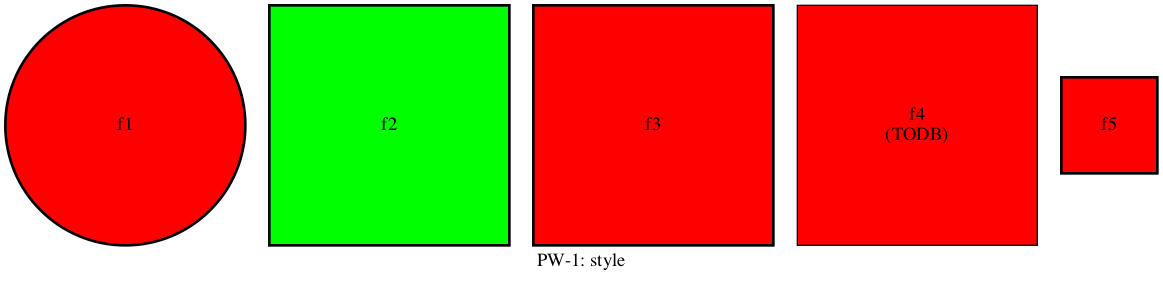

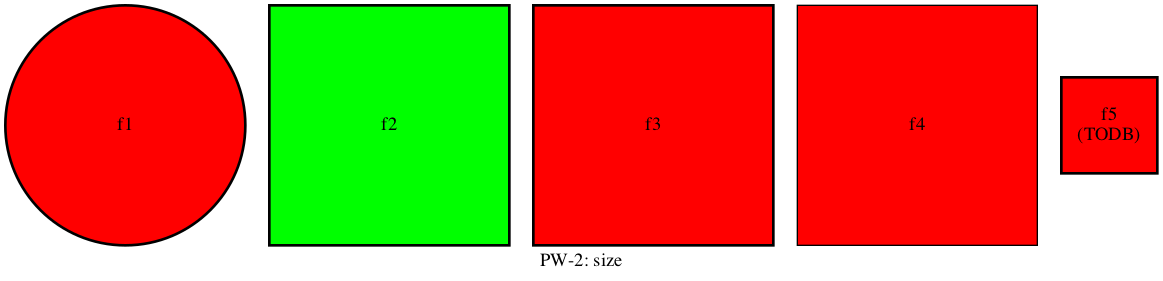

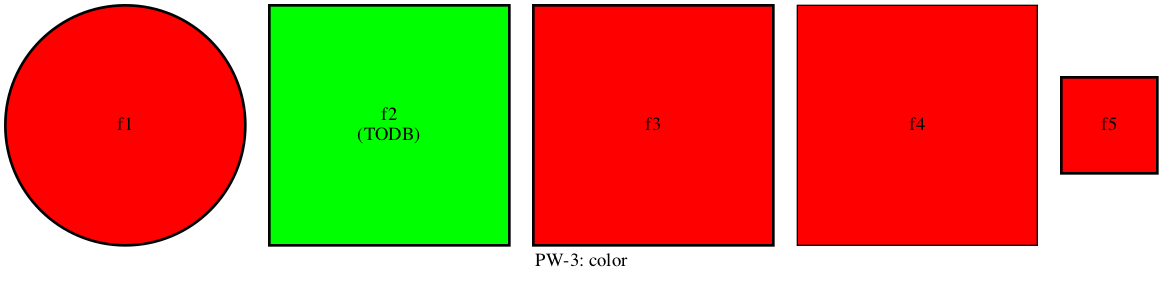

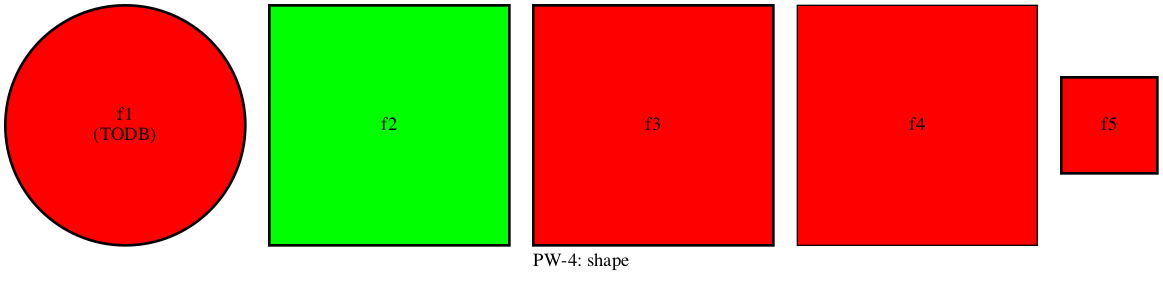

In [53]:
for i in range(1, len(unique_prop_val_exp['pw_objects'])+1):
    pw_i_rels_dfs, _ = pw_slicer(unique_prop_val_exp['pws_rels_dfs'], None, [i])
    reason_df = pw_i_rels_dfs['soln_2']
    todb_reason = reason_df.iloc[0]['x2']
    g = WODBVizLib.visualize_wodb_query_instance(pw_i_rels_dfs['propDB_3'], 
                                      pw_i_rels_dfs['soln_1'], 
                                      graph_label='PW-{}: {}'.format(str(i), todb_reason))
    display(draw(g))

As we can see above, all figures except figure-3 had something special about them.

Is being the only non-special one also special?

##### Query: Special because NOT Special ?!?

How do you write a query to check for this special type of specialness (meta-specialness)?

In [54]:
%%clingo -lci meta_special_query --donot-display_input --donot-run

% figure F and figure F1 both have the same value for their property P
shared_prop(F,F1,P,V) :- propDB(F,P,V), propDB(F1,P,V), F != F1.

% figure F is special wrt property P
special_fig_prop(F,P) :- prop(P), propDB(F,P,V), not shared_prop(F,_,P,V).

% figure F is special wrt some property
special_fig(F) :- special_fig_prop(F,_).

% figure F is not special (wrt any property)
% ... which is the distinguishing "meta-property"
% ... making F special in *that* sense !!
not_special(F) :- propDB(F,_,_), not special_fig(F).

soln(F) :- not_special(F).

soln_count(N) :-  #count {F: soln(F)} = N.
:- soln_count(N), N <= 0.

In [55]:
%%clingo -l meta_special_query database_schema db4 --donot-display_input

#show soln/1.

Output:


'Answer: 1\nsoln(f3)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

As we alluded to earlier at the beginning of the notebook, figures-1,2,4,5 all seem to be unique wrt some property, which means figure-3 is the only one not to be special wrt to any property, which makes it special in a meta sense.

In [56]:
%clingo -l meta_special_query database_schema db4 --donot-display_input --donot-display_output -exp meta_special_exp

In [57]:
meta_special_exp['pws_rels_dfs'], meta_special_exp['rel_schemas'], meta_special_exp['pw_objects'] \
= load_worlds(meta_special_exp['asp_soln'], meta_data=meta_special_exp['meta_data'])

Number of Models: 1


As earlier, we can visualize the solution.

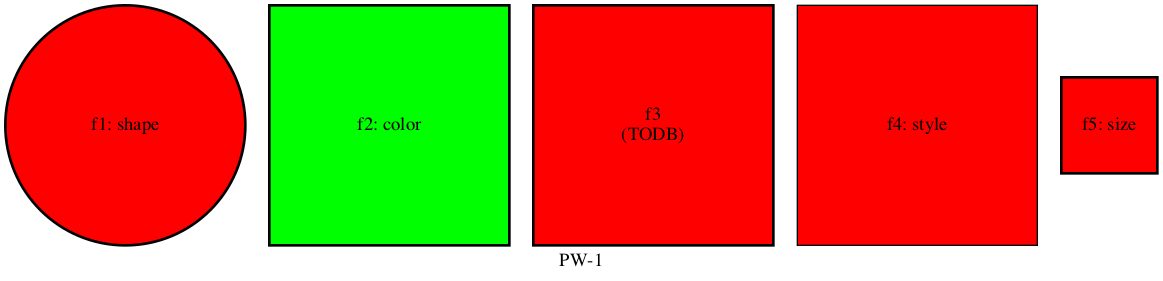

In [58]:
for i in range(1, len(meta_special_exp['pw_objects'])+1):
    pw_i_rels_dfs, _ = pw_slicer(meta_special_exp['pws_rels_dfs'], None, [i])
    reason_df = pw_i_rels_dfs['special_fig_prop_2']
    g = WODBVizLib.visualize_wodb_query_instance(pw_i_rels_dfs['propDB_3'], 
                                      pw_i_rels_dfs['soln_1'], 
                                      graph_label='PW-{}'.format(str(i)))
    for i, row in reason_df.iterrows():
        figID, todb_reason = row['x1'], row['x2']
        if 'label' not in g.nodes[figID]:
            g.nodes[figID]['label'] = figID
        g.nodes[figID]['label'] += ": {}".format(todb_reason)
        
    display(draw(g))

As we can see, f1 is special because of its unique shape, f2 is special because of its unique color, f4 is special because of its unique style and so on, making f3 the one that stand out

#### PWE-Based Analysis:

In [59]:
%clingo -l pick_one_fig_query database_schema db4 --donot-display_input --donot-display_output -exp pick_one_exp

In [60]:
pick_one_exp['pws_rels_dfs'], pick_one_exp['rel_schemas'], pick_one_exp['pw_objects'] \
= load_worlds(pick_one_exp['asp_soln'], meta_data=pick_one_exp['meta_data'], silent=True)

##### DB Query Based Analysis (similar to the unique_property_value_query)

In [61]:
_ = PWEQuery.unique_tuples(expected_pws=len(pick_one_exp['pw_objects']), 
                           dfs=pick_one_exp['pws_rels_dfs'], 
                           rl_name='soln_propDB_2')

The unique tuple  ('shape', 'circle') occurs only in PW 1
The unique tuple  ('size', 'small') occurs only in PW 2
The unique tuple  ('style', 'thin') occurs only in PW 3
The unique tuple  ('color', 'green') occurs only in PW 4


The above query finds tuples that exists in exactly one PW.

As we can see here, PW-5 (fig3) doesn't have any unique tuple, the only one to not have any unique tuples.

#### Is there way to "realize" the meta-specialness we discovered earlier, using PWE?

Yes! In fact as we'll show, our current analysis based on the symmetic difference distance will hint at this special-ness of Figure-3.

##### Distance Metric Based Analysis

We repeat the distance metric analysis from earlier which is based on the size of the symmetric set difference.

In [62]:
num_pws = len(pick_one_exp['pw_objects'])
dist_matrix = np.zeros((num_pws, num_pws))
for i in range(num_pws):
    for j in range(i+1, num_pws):
        dist_matrix[i][j] = \
            dist_matrix[j][i] = \
                PWEDistanceCalculation.sym_diff_dist(pw_id_1=i+1, pw_id_2=j+1, 
                                                     relations=pick_one_exp['rel_schemas'],
                                                     dfs=pick_one_exp['pws_rels_dfs'],
                                                     pws=pick_one_exp['pw_objects'],
                                                     rls_to_use=['soln_propDB_2'])
        
pd.DataFrame(dist_matrix, index=range(1,len(dist_matrix)+1), columns=range(1, len(dist_matrix)+1))

,1,2,3,4,5
1,0.0,4.0,4.0,4.0,2.0
2,4.0,0.0,4.0,4.0,2.0
3,4.0,4.0,0.0,4.0,2.0
4,4.0,4.0,4.0,0.0,2.0
5,2.0,2.0,2.0,2.0,0.0


We can already see here that while PWs-1,2,3,4 are all at a distance of 4 from each other, PW-5 is at a distance of 2 from the rest of the PWs.

We can visualize these PWs based on the distance matrix above to get a better visual sense of this.

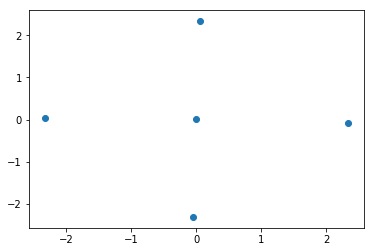

In [63]:
_ = PWEVisualization.mds_sklearn(dist_matrix)

As we can see (well it's not labelled here), but we have 5 clusters, but one of them is special in that it's equidistant from all the others.

As we can see PW-5 (in the middle) stands out from the rest.

We can also visualize the distance matrix in more informative and visually appealing ways such as a cluster-map as shown below:

/anaconda3/envs/LeanEuler-prod-env/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


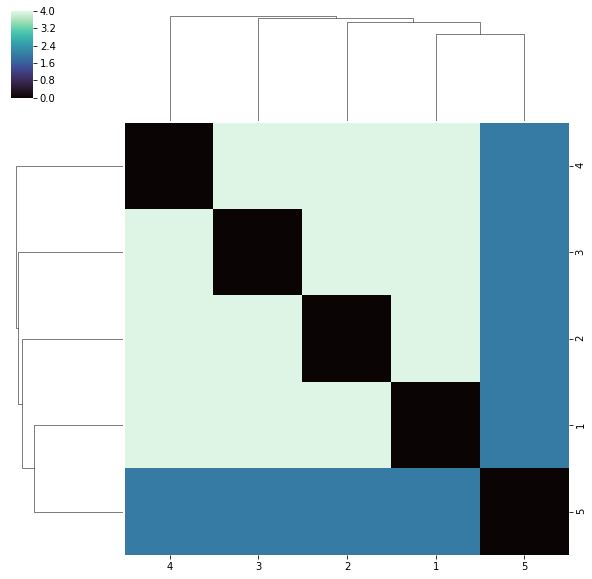

In [64]:
_ = PWEVisualization.cluster_map_viz(dist_matrix)

###### As we can observe, in all of these analyses, PW-5 (fig1) stands out, similar to results of our meta_special_query from earlier.

##### This also illustrates that even for a fixed database, the choice of query is crucial! There's no one "best" query, but rather there's (almost) always one that would fit your needs and criteria the best.

##### So in conclusion, both the choice of data representation in the DB, and the query we choose to run on this DB are crucial components of an analysis task such as finding WODB. In addition we've shown that this can be done in ASP as well as outside it in tools like PWE. Both have their advantages. For example, ASP queries are more portable, age well and are easier to reason about, while PWE/Python based analysis is more flexible, allows more interesting forms of analysis such as distance calculations/transformations on a continuous space, etc. A tool like PWE, therefore, allows us to get the best of both worlds!